### Fine tuning example

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Load CIFAR-10 dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(type(x_train))
# <class 'numpy.ndarray'>

print(x_train.shape, y_train.shape)
# (50000, 32, 32, 3) (50000, 1)

print(x_test.shape, y_test.shape)
# (10000, 32, 32, 3) (10000, 1)

170500096/170498071 [==============================] - 11s 0us/step
<class 'numpy.ndarray'>
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [3]:

print(type(x_train[0]))
print(type(y_train[0]))
print(y_train[0].dtype)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
uint8


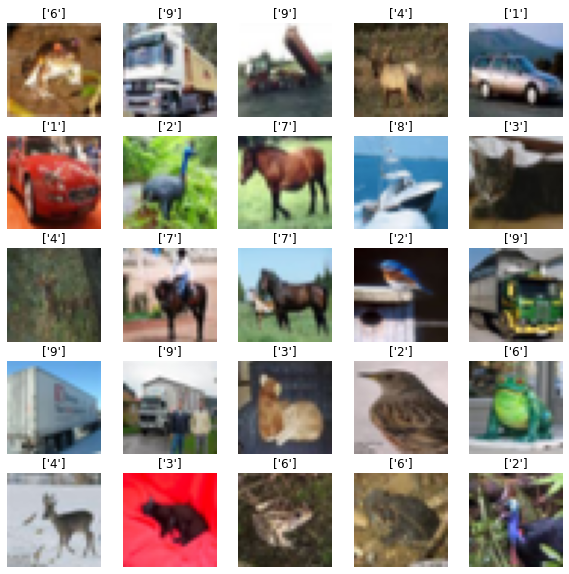

In [4]:
# visualize samples
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title((y_train[i].astype(str)))
    plt.axis("off")

### model download
Load VGG16 pre-trained with ImageNet network model. 



In [5]:
inputs = tf.keras.Input(shape=(None, None, 3))
# change input image size 32x32 -> 160x160  
x = tf.keras.layers.Lambda(lambda img: tf.image.resize(img, (160, 160)))(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
core = tf.keras.applications.VGG16(
    include_top=False, weights='imagenet', input_tensor=x,
    input_shape=(160,160,3), pooling='ave', classes=1000
)

model = tf.keras.Sequential([
    core,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

print('core pre-trained VGG16 network')
core.summary()

print('\n\n our network to be trained')
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
core pre-trained VGG16 network
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
lambda (Lambda)              (None, 160, 160, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 160, 160, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_______________________________

### we train only additional part (freeze VGG16）

train only 12800 x 10 (output)

In [6]:
core.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                128010    
Total params: 14,842,698
Trainable params: 128,010
Non-trainable params: 14,714,688
_________________________________________________________________


compile model

In [7]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

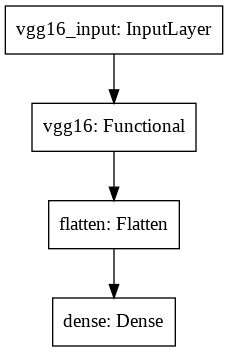

In [13]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

See performance before the training

return: [loss, accuracy] 



Note: loss is in cross-entropy and this is 10 class classification.

In [8]:
print(model.evaluate(x_test, y_test, verbose=0))


[14.018341064453125, 0.09470000118017197]


### Train the network

If you train 10 epochs (5-6min with GPU), validation accuracy reaches around 84-85%

In [9]:
EPOCH = 10
stack = model.fit(x_train, y_train, epochs=EPOCH, validation_split=0.2, batch_size=256)

Epoch 1/10
157/157 [==============================] - 56s 291ms/step - loss: 3.0127 - accuracy: 0.6257 - val_loss: 1.7321 - val_accuracy: 0.7586
Epoch 2/10
157/157 [==============================] - 42s 271ms/step - loss: 1.1453 - accuracy: 0.8183 - val_loss: 1.3188 - val_accuracy: 0.8078
Epoch 3/10
157/157 [==============================] - 43s 272ms/step - loss: 0.7185 - accuracy: 0.8697 - val_loss: 1.2096 - val_accuracy: 0.8206
Epoch 4/10
157/157 [==============================] - 43s 272ms/step - loss: 0.4795 - accuracy: 0.9010 - val_loss: 1.1513 - val_accuracy: 0.8235
Epoch 5/10
157/157 [==============================] - 43s 272ms/step - loss: 0.3247 - accuracy: 0.9242 - val_loss: 1.0954 - val_accuracy: 0.8327
Epoch 6/10
157/157 [==============================] - 43s 272ms/step - loss: 0.2180 - accuracy: 0.9461 - val_loss: 1.0963 - val_accuracy: 0.8333
Epoch 7/10
157/157 [==============================] - 43s 272ms/step - loss: 0.1484 - accuracy: 0.9610 - val_loss: 1.0810 - val_ac

In [10]:
# performance for test data
print(model.evaluate(x_test, y_test, verbose=0))


[1.0825837850570679, 0.8440999984741211]


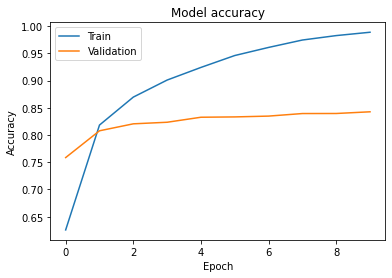

In [18]:
#print(stack.history)
plt.plot(stack.history['accuracy'])
plt.plot(stack.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

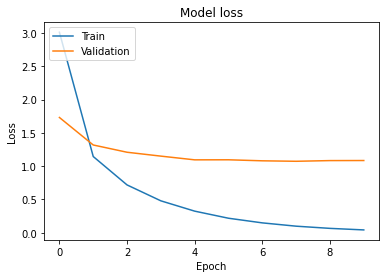

In [19]:
plt.plot(stack.history['loss'])
plt.plot(stack.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### We expand the fine-tuned weights.

In the above, we fine-tune only the last 'dence_1' (12800 x 10) part.

We include 'block5' (the last three conv layers) part for fine-tuning.  

In [ ]:
layer_names = [l.name for l in core.layers]
print (layer_names)

idx = layer_names.index('block5_conv1')
print(idx)

['input_3', 'lambda_2', 'tf.__operators__.getitem_2', 'tf.nn.bias_add_2', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']
18


In [ ]:
core.trainable = True

# layer 18 (block_conv1 does NOT include)
for layer in core.layers[:idx]:
    layer.trainable = False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                128010    
Total params: 14,842,698
Trainable params: 7,207,434
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, epochs=5, validation_split=0.2, batch_size=256)

Epoch 1/5
157/157 [==============================] - 50s 311ms/step - loss: 0.0232 - accuracy: 0.9950 - val_loss: 1.0724 - val_accuracy: 0.8516
Epoch 2/5
157/157 [==============================] - 48s 309ms/step - loss: 0.0048 - accuracy: 0.9995 - val_loss: 1.0903 - val_accuracy: 0.8556
Epoch 3/5
157/157 [==============================] - 48s 309ms/step - loss: 0.0017 - accuracy: 0.9999 - val_loss: 1.1201 - val_accuracy: 0.8610
Epoch 4/5
157/157 [==============================] - 48s 309ms/step - loss: 7.6971e-04 - accuracy: 0.9999 - val_loss: 1.1166 - val_accuracy: 0.8616
Epoch 5/5
157/157 [==============================] - 48s 308ms/step - loss: 2.9954e-04 - accuracy: 1.0000 - val_loss: 1.1501 - val_accuracy: 0.8652
